In [1]:
# In this experiment we will take the 3 best models from the previous experiment and train them on the new dataset created.
# We will then evaluate the models on the test set.
import os

from fastai.vision.all import *
from fastai.vision import *

import pandas as pd
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix


In [8]:
available_models = {
    'alexnet': models.alexnet,
    'resnet101': models.resnet101,
    'squeezenet1_1': models.squeezenet1_1,
}

datasets_paths = {
    '1x': {
        'train': '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/trichome_dataset',
        'test': '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44/trichome_dataset',
    },
    '1.1x': {
        'train': '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/trichome_dataset_01',
        'test': '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44/trichome_dataset_01',
    },
    '1.25x': {
        'train': '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/trichome_dataset_025',
        'test': '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44/trichome_dataset_025',
    },
    '1.5x': {
        'train': '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/trichome_dataset_05',
        'test': '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44/trichome_dataset_05',
    },
    '1.75x': {
        'train': '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/trichome_dataset_075',
        'test': '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44/trichome_dataset_075',
    },
    '2x': {
        'train': '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/trichome_dataset_1',
        'test': '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44/trichome_dataset_1',
    },
}

# define train metrics
precision_macro_fastai = Precision(average='macro')
recall_macro_fastai = Recall(average='macro')
roc_auc_fastai = RocAuc()


# transformation and image space conversion
def custom_transform(size):
    return Resize(size, method='pad', pad_mode='zeros')

class RGB2HSV(Transform):
    def encodes(self, img: PILImage): 
        return rgb2hsv(img)
    
    
global_item_tfms=custom_transform(size=128),  # Resize and HSV transform
global_batch_tfms=[
    RGB2HSV(),
    *aug_transforms(size=128, flip_vert=True, max_rotate=10),
    Brightness(max_lighting=0.2, p=0.75),
    Contrast(max_lighting=0.2, p=0.75),
]

# results placeholder
results = {}

In [14]:
for dataset, paths in datasets_paths.items():
    print(f"Training on dataset size: {dataset}")
    # get paths
    train_path = paths['train']
    test_path = paths['test']
    
    # define train dataloader
    dls = ImageDataLoaders.from_folder(
        path=train_path,
        item_tfms=global_item_tfms,
        batch_tfms=global_batch_tfms,
        bs=16,
        valid_pct=0.25
    )
    
    results[dataset] = {}
    
    for model_name, model_fn in available_models.items():
        print(f"Training model: {model_name}")
        
        model = vision_learner(
            dls=dls,
            arch=model_fn,
            metrics=[error_rate, precision_macro_fastai, recall_macro_fastai, roc_auc_fastai]
        )

        model.fine_tune(epochs=50)
        
        # Create the test DataLoader with the same transformations
        test_dl = dls.test_dl(get_image_files(test_path), with_labels=True, 
                            item_tfms=global_item_tfms, batch_tfms=global_batch_tfms)

        # Evaluate on the test set
        preds, targs = model.get_preds(dl=test_dl)

        pred_classes = preds.argmax(dim=1).numpy()
        true_classes = targs.numpy()

        # calc macro precision and recall
        precision_macro = precision_score(true_classes, pred_classes, average='macro')
        recall_macro = recall_score(true_classes, pred_classes, average='macro')

        # calc weighted precision and recall
        precision_weighted = precision_score(true_classes, pred_classes, average='weighted')
        recall_weighted = recall_score(true_classes, pred_classes, average='weighted')
        
        accuracy = accuracy_score(true_classes, pred_classes)
        conf_matrix = confusion_matrix(true_classes, pred_classes)
        
        # Calculate precision and recall for each class
        precision_per_class = precision_score(true_classes, pred_classes, average=None)
        recall_per_class = recall_score(true_classes, pred_classes, average=None)


        results[dataset][model_name] = {
            'precision_macro': precision_macro,
            'recall_macro': recall_macro,
            'precision_weighted': precision_weighted,
            'recall_weighted': recall_weighted,
            'precision_per_class': precision_per_class,
            'recall_per_class': recall_per_class,
            'accuracy': accuracy,
            'confusion_matrix': conf_matrix,
            'pred_classes': pred_classes,
            'true_classes': true_classes
        }
        
        print(f"Results for model {model_name}:")
        print(f"Precision Macro: {precision_macro}")
        print(f"Recall Macro: {recall_macro}")
        print(f"Precision Weighted: {precision_weighted}")
        print(f"Recall Weighted: {recall_weighted}")
        print(f"Accuracy: {accuracy}")
        print(f"Confusion Matrix:\n{conf_matrix}")
        print(f"Precision per Class: {precision_per_class}")
        print(f"Recall per Class: {recall_per_class}")
        print("\n\n")
    


Training on dataset size: 1x
Training model: alexnet


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.413392,0.940304,0.398537,0.608297,0.615663,0.790207,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.182178,0.802833,0.363803,0.654601,0.630867,0.810805,00:03
1,1.067278,0.750821,0.347349,0.667337,0.643441,0.824539,00:02
2,1.008818,0.798218,0.351005,0.657032,0.631314,0.804262,00:02
3,1.019637,0.713965,0.308958,0.709175,0.669012,0.833656,00:02
4,0.881111,0.708559,0.332724,0.678091,0.658774,0.834778,00:02
5,0.880696,0.678309,0.303474,0.704264,0.683540,0.845251,00:03
6,0.831170,0.688385,0.296161,0.710688,0.699659,0.838735,00:03
7,0.803123,0.671959,0.290676,0.708885,0.688847,0.852335,00:02
8,0.760388,0.694477,0.318099,0.706851,0.658927,0.834264,00:02
9,0.725437,0.726681,0.323583,0.705927,0.663329,0.828108,00:03


Results for model alexnet:
Precision Macro: 0.76188107990746
Recall Macro: 0.7484270731397168
Precision Weighted: 0.7321696963905073
Recall Weighted: 0.7276190476190476
Accuracy: 0.7276190476190476
Confusion Matrix:
[[ 64   6   7]
 [  2 136  78]
 [  8  42 182]]
Precision per Class: [0.86486486 0.73913043 0.68164794]
Recall per Class: [0.83116883 0.62962963 0.78448276]



Training model: resnet101


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.830753,1.470162,0.493601,0.464142,0.483072,0.674434,00:08


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.379866,1.065124,0.442413,0.542152,0.553394,0.744105,00:12
1,1.176115,0.902876,0.402194,0.586668,0.582281,0.784021,00:12
2,1.089395,0.898664,0.413163,0.570441,0.566961,0.772847,00:12
3,1.012943,0.870270,0.404022,0.584215,0.605925,0.777600,00:12
4,0.919504,0.860406,0.425960,0.602637,0.556864,0.783684,00:12
5,0.888381,0.832942,0.422303,0.591972,0.542771,0.781998,00:12
6,0.829075,0.760776,0.340037,0.709169,0.579596,0.805595,00:12
7,0.808480,0.795728,0.356490,0.693855,0.588012,0.799510,00:12
8,0.729364,0.733746,0.327239,0.711311,0.643137,0.813436,00:12
9,0.731745,0.708042,0.340037,0.685189,0.636245,0.830170,00:12


Results for model resnet101:
Precision Macro: 0.74270373825496
Recall Macro: 0.6935363487087626
Precision Weighted: 0.7021557409417729
Recall Weighted: 0.6933333333333334
Accuracy: 0.6933333333333334
Confusion Matrix:
[[ 54   6  17]
 [  4 135  77]
 [  3  54 175]]
Precision per Class: [0.8852459  0.69230769 0.65055762]
Recall per Class: [0.7012987  0.625      0.75431034]



Training model: squeezenet1_1


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.505388,0.892600,0.380256,0.590365,0.612923,0.804881,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.124960,0.776950,0.336380,0.657012,0.641153,0.825013,00:03
1,1.060462,0.722219,0.327239,0.658180,0.687777,0.844922,00:04
2,0.968809,0.698788,0.329068,0.687327,0.638676,0.838430,00:04
3,0.907445,0.729332,0.330896,0.658536,0.670384,0.834026,00:04
4,0.890918,0.717527,0.316271,0.671075,0.680962,0.837005,00:04
5,0.839260,0.624526,0.283364,0.726214,0.699401,0.866341,00:03
6,0.829513,0.727189,0.323583,0.663120,0.683738,0.831789,00:04
7,0.839526,0.674172,0.296161,0.718648,0.672734,0.848394,00:03
8,0.789774,0.659561,0.305302,0.721851,0.675469,0.843773,00:04
9,0.788206,0.813223,0.405850,0.634741,0.618545,0.826245,00:03


Results for model squeezenet1_1:
Precision Macro: 0.7437212496107534
Recall Macro: 0.7065952353308674
Precision Weighted: 0.708382075035208
Recall Weighted: 0.6971428571428572
Accuracy: 0.6971428571428572
Confusion Matrix:
[[ 58   6  13]
 [  4 122  90]
 [  5  41 186]]
Precision per Class: [0.86567164 0.72189349 0.64359862]
Recall per Class: [0.75324675 0.56481481 0.80172414]



Training on dataset size: 1.1x
Training model: alexnet


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.558198,0.869388,0.352834,0.670276,0.622359,0.786421,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.240295,0.738366,0.323583,0.705001,0.658625,0.827876,00:02
1,1.077612,0.728289,0.329068,0.696036,0.657458,0.830788,00:02
2,1.061702,0.691272,0.307130,0.712320,0.675702,0.840456,00:02
3,1.020128,0.671604,0.308958,0.708079,0.672771,0.844913,00:02
4,0.946777,0.715245,0.323583,0.685535,0.676399,0.834919,00:02
5,0.921766,0.657478,0.285192,0.744037,0.710214,0.852869,00:03
6,0.835841,0.649187,0.299817,0.737300,0.689037,0.854437,00:03
7,0.804470,0.625479,0.281536,0.753093,0.721500,0.863407,00:02
8,0.770614,0.616998,0.296161,0.711560,0.736115,0.870622,00:02
9,0.780474,0.602046,0.281536,0.755269,0.708625,0.870727,00:02


Results for model alexnet:
Precision Macro: 0.8014809000523285
Recall Macro: 0.7791530521415578
Precision Weighted: 0.7700413944332312
Recall Weighted: 0.7542857142857143
Accuracy: 0.7542857142857143
Confusion Matrix:
[[ 68   1   8]
 [  4 127  85]
 [  3  28 201]]
Precision per Class: [0.90666667 0.81410256 0.68367347]
Recall per Class: [0.88311688 0.58796296 0.86637931]



Training model: resnet101


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.848134,1.431007,0.464351,0.498229,0.540002,0.708001,00:09


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.439243,1.071451,0.424132,0.554881,0.557960,0.734513,00:12
1,1.267156,0.999791,0.409506,0.569103,0.549363,0.747962,00:12
2,1.117335,0.942755,0.409506,0.585722,0.574344,0.756315,00:12
3,1.026073,0.842620,0.389397,0.631548,0.594519,0.769851,00:12
4,1.027152,0.804498,0.382084,0.610507,0.635915,0.792026,00:12
5,0.881791,0.815013,0.371115,0.668207,0.613057,0.780988,00:12
6,0.837991,0.720421,0.347349,0.671841,0.668730,0.812126,00:12
7,0.840815,0.723709,0.352834,0.678362,0.645976,0.821681,00:12
8,0.775118,0.684275,0.318099,0.708708,0.678373,0.842106,00:12
9,0.737621,0.656024,0.287020,0.728951,0.688390,0.847848,00:12


Results for model resnet101:
Precision Macro: 0.7505367714340107
Recall Macro: 0.7321622077369203
Precision Weighted: 0.713604042254349
Recall Weighted: 0.7047619047619048
Accuracy: 0.7047619047619048
Confusion Matrix:
[[ 65   4   8]
 [  5 118  93]
 [  4  41 187]]
Precision per Class: [0.87837838 0.72392638 0.64930556]
Recall per Class: [0.84415584 0.5462963  0.80603448]



Training model: squeezenet1_1


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.473833,0.967032,0.400366,0.632375,0.528193,0.779049,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.199720,0.758875,0.330896,0.676508,0.636578,0.821060,00:04
1,1.025766,0.698054,0.321755,0.708062,0.634476,0.840017,00:04
2,0.973695,0.691867,0.325411,0.711767,0.647682,0.839046,00:03
3,0.934576,0.658520,0.305302,0.720170,0.695988,0.853526,00:04
4,0.878556,0.711962,0.305302,0.733438,0.655471,0.839112,00:03
5,0.854633,0.678292,0.294333,0.732444,0.662774,0.844539,00:04
6,0.822285,0.666111,0.316271,0.707427,0.666923,0.844047,00:04
7,0.796821,0.700975,0.332724,0.725500,0.624129,0.834839,00:04
8,0.738767,0.665806,0.319927,0.740255,0.654656,0.840807,00:04
9,0.746438,0.840649,0.343693,0.756932,0.639993,0.851888,00:04


Results for model squeezenet1_1:
Precision Macro: 0.7939127822490498
Recall Macro: 0.7271199957981566
Precision Weighted: 0.7472848200312989
Recall Weighted: 0.7180952380952381
Accuracy: 0.7180952380952381
Confusion Matrix:
[[ 60   3  14]
 [  3 112 101]
 [  0  27 205]]
Precision per Class: [0.95238095 0.78873239 0.640625  ]
Recall per Class: [0.77922078 0.51851852 0.88362069]



Training on dataset size: 1.25x
Training model: alexnet


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.565547,1.018037,0.411335,0.542182,0.568432,0.734612,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.163336,0.792014,0.352834,0.641763,0.622433,0.803495,00:02
1,1.065872,0.782684,0.345521,0.621745,0.640759,0.816676,00:03
2,1.014203,0.711430,0.318099,0.725262,0.644690,0.833803,00:03
3,1.016869,0.681076,0.303474,0.711241,0.687996,0.846041,00:02
4,0.893228,0.664195,0.305302,0.701951,0.698282,0.852798,00:02
5,0.886096,0.648498,0.294333,0.720635,0.694411,0.857375,00:02
6,0.816709,0.677877,0.294333,0.752931,0.647074,0.836672,00:02
7,0.787560,0.654213,0.312614,0.711614,0.673596,0.841850,00:02
8,0.733368,0.683169,0.297989,0.796331,0.624157,0.850742,00:03
9,0.733131,0.589808,0.266910,0.742284,0.744493,0.876155,00:02


Results for model alexnet:
Precision Macro: 0.7769745069745069
Recall Macro: 0.7501271610467013
Precision Weighted: 0.7492329004329005
Recall Weighted: 0.7409523809523809
Accuracy: 0.7409523809523809
Confusion Matrix:
[[ 61   3  13]
 [  4 139  73]
 [  5  38 189]]
Precision per Class: [0.87142857 0.77222222 0.68727273]
Recall per Class: [0.79220779 0.64351852 0.81465517]



Training model: resnet101


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.949526,1.621136,0.468007,0.484621,0.512279,0.682180,00:09


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.384849,1.101817,0.435101,0.527173,0.554653,0.733290,00:12
1,1.259356,0.994263,0.425960,0.538903,0.565504,0.745608,00:12
2,1.145054,0.838447,0.367459,0.618044,0.587262,0.773311,00:12
3,1.053558,0.917503,0.424132,0.574896,0.547605,0.758327,00:12
4,0.984013,0.820346,0.400366,0.597831,0.560713,0.768414,00:12
5,0.914986,0.849401,0.394881,0.613588,0.608549,0.790588,00:12
6,0.857961,0.787533,0.349177,0.621597,0.640027,0.794422,00:12
7,0.818962,0.775396,0.340037,0.686685,0.636678,0.793211,00:12
8,0.775030,0.754838,0.341865,0.654084,0.685052,0.819641,00:12
9,0.718709,0.781845,0.312614,0.674534,0.698592,0.823468,00:12


Results for model resnet101:
Precision Macro: 0.7903083920627779
Recall Macro: 0.7794032276790898
Precision Weighted: 0.7584977829188355
Recall Weighted: 0.7466666666666667
Accuracy: 0.7466666666666667
Confusion Matrix:
[[ 70   0   7]
 [  2 129  85]
 [  6  33 193]]
Precision per Class: [0.8974359  0.7962963  0.67719298]
Recall per Class: [0.90909091 0.59722222 0.83189655]



Training model: squeezenet1_1


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.525742,1.866113,0.383912,0.594167,0.565110,0.734576,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.117945,0.929113,0.360146,0.617220,0.619123,0.790445,00:03
1,1.056019,0.810257,0.365631,0.606144,0.568991,0.804231,00:03
2,0.992747,0.775725,0.305302,0.688892,0.650651,0.825253,00:04
3,0.986584,0.797127,0.369287,0.653271,0.555317,0.798485,00:04
4,0.928028,0.696888,0.336380,0.676948,0.641624,0.843502,00:03
5,0.805920,0.692845,0.305302,0.736458,0.666847,0.844937,00:04
6,0.834489,0.671577,0.307130,0.749621,0.641263,0.854927,00:04
7,0.816320,0.683106,0.305302,0.702571,0.652797,0.843810,00:04
8,0.915763,1.088552,0.438757,0.570422,0.589941,0.720945,00:04
9,0.835657,0.965117,0.363803,0.695900,0.561738,0.782895,00:04


Results for model squeezenet1_1:
Precision Macro: 0.777332632456794
Recall Macro: 0.7165462783278875
Precision Weighted: 0.7312828803617689
Recall Weighted: 0.7104761904761905
Accuracy: 0.7104761904761905
Confusion Matrix:
[[ 58   2  17]
 [  3 121  92]
 [  1  37 194]]
Precision per Class: [0.93548387 0.75625    0.64026403]
Recall per Class: [0.75324675 0.56018519 0.8362069 ]



Training on dataset size: 1.5x
Training model: alexnet


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.537336,1.091070,0.457038,0.508968,0.554952,0.714724,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.181836,0.847131,0.358318,0.663337,0.622460,0.787106,00:02
1,1.083680,0.800485,0.352834,0.656057,0.635547,0.796529,00:02
2,0.978078,0.734534,0.334552,0.700427,0.643991,0.818310,00:02
3,0.929105,0.727022,0.341865,0.693660,0.627780,0.824329,00:03
4,0.877181,0.699739,0.332724,0.679226,0.655731,0.836748,00:02
5,0.808486,0.680690,0.316271,0.710068,0.668008,0.845712,00:02
6,0.818014,0.671696,0.283364,0.716967,0.717775,0.854201,00:02
7,0.779579,0.658804,0.288848,0.753989,0.698244,0.846223,00:03
8,0.699712,0.687000,0.277879,0.765294,0.687456,0.851461,00:03
9,0.705379,0.682787,0.297989,0.720600,0.704233,0.859697,00:03


Results for model alexnet:
Precision Macro: 0.7683847736625514
Recall Macro: 0.7500608161527702
Precision Weighted: 0.735521693121693
Recall Weighted: 0.7238095238095238
Accuracy: 0.7238095238095238
Confusion Matrix:
[[ 66   0  11]
 [  5 124  87]
 [  4  38 190]]
Precision per Class: [0.88       0.7654321  0.65972222]
Recall per Class: [0.85714286 0.57407407 0.81896552]



Training model: resnet101


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.875115,1.518596,0.484461,0.473554,0.505894,0.662393,00:09


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.489086,1.107721,0.440585,0.534164,0.530558,0.700214,00:12
1,1.281269,1.001218,0.431444,0.552122,0.548182,0.706658,00:12
2,1.168328,0.906108,0.404022,0.582807,0.574599,0.751128,00:12
3,1.120613,0.853027,0.387569,0.609181,0.606326,0.770840,00:12
4,0.968093,0.791272,0.391225,0.609841,0.621233,0.783254,00:12
5,0.938574,0.770806,0.365631,0.641600,0.612466,0.795546,00:12
6,0.856660,0.749718,0.367459,0.647444,0.621149,0.811208,00:12
7,0.817257,0.737272,0.360146,0.644789,0.636847,0.819663,00:12
8,0.753075,0.737323,0.334552,0.671117,0.664640,0.825109,00:12
9,0.710820,0.732715,0.312614,0.689051,0.651674,0.823885,00:12


Results for model resnet101:
Precision Macro: 0.7581254724111867
Recall Macro: 0.7451996704870268
Precision Weighted: 0.735322319403952
Recall Weighted: 0.7219047619047619
Accuracy: 0.7219047619047619
Confusion Matrix:
[[ 65   3   9]
 [  7 119  90]
 [  6  31 195]]
Precision per Class: [0.83333333 0.77777778 0.66326531]
Recall per Class: [0.84415584 0.55092593 0.84051724]



Training model: squeezenet1_1


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.527708,1.139176,0.447898,0.544831,0.503903,0.714665,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.286286,0.877505,0.361974,0.640432,0.604516,0.774065,00:04
1,1.101589,0.788865,0.358318,0.673974,0.612423,0.791230,00:04
2,0.998592,0.768617,0.330896,0.683750,0.638095,0.807096,00:04
3,0.937791,0.746221,0.351005,0.652176,0.641296,0.809894,00:04
4,0.931415,0.741915,0.340037,0.686099,0.609573,0.809624,00:04
5,0.882793,0.756902,0.345521,0.684070,0.617078,0.813706,00:03
6,0.847688,0.815387,0.351005,0.655350,0.648253,0.808709,00:04
7,0.826126,0.739084,0.332724,0.696680,0.661605,0.817653,00:03
8,0.783422,0.713065,0.327239,0.676638,0.660889,0.821165,00:04
9,0.717594,0.716173,0.321755,0.688743,0.668841,0.829288,00:04


Results for model squeezenet1_1:
Precision Macro: 0.7748085783762692
Recall Macro: 0.7188158265744473
Precision Weighted: 0.7327554192595939
Recall Weighted: 0.7161904761904762
Accuracy: 0.7161904761904762
Confusion Matrix:
[[ 57   3  17]
 [  2 129  85]
 [  3  39 190]]
Precision per Class: [0.91935484 0.75438596 0.65068493]
Recall per Class: [0.74025974 0.59722222 0.81896552]



Training on dataset size: 1.75x
Training model: alexnet


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.573855,1.111036,0.433272,0.530267,0.549532,0.716707,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.207783,0.829883,0.376600,0.608776,0.591933,0.784383,00:03
1,1.116458,0.777795,0.363803,0.629844,0.609857,0.800460,00:03
2,1.061643,0.741582,0.347349,0.684804,0.620337,0.813739,00:03
3,0.977702,0.716442,0.327239,0.695630,0.657300,0.825635,00:03
4,0.919288,0.698772,0.340037,0.698706,0.652408,0.836023,00:02
5,0.840741,0.682623,0.314442,0.706835,0.700157,0.843073,00:03
6,0.827273,0.652944,0.310786,0.706854,0.676988,0.848582,00:02
7,0.802545,0.626193,0.288848,0.734956,0.704224,0.864620,00:02
8,0.749511,0.651179,0.310786,0.725061,0.680139,0.847745,00:03
9,0.692130,0.603051,0.266910,0.778702,0.728310,0.875857,00:03


Results for model alexnet:
Precision Macro: 0.7180326903450416
Recall Macro: 0.6792618301238992
Precision Weighted: 0.6714767541182052
Recall Weighted: 0.659047619047619
Accuracy: 0.659047619047619
Confusion Matrix:
[[ 59   3  15]
 [  5 108 103]
 [  3  50 179]]
Precision per Class: [0.88059701 0.67080745 0.6026936 ]
Recall per Class: [0.76623377 0.5        0.77155172]



Training model: resnet101


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.995576,1.586338,0.515539,0.434484,0.429620,0.620609,00:09


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.525039,1.108481,0.468007,0.490638,0.476639,0.687344,00:12
1,1.321043,0.973465,0.442413,0.529971,0.521023,0.717398,00:12
2,1.179692,0.911430,0.416819,0.570543,0.514301,0.723165,00:12
3,1.071508,0.873134,0.413163,0.581323,0.511695,0.757655,00:12
4,1.016468,0.878349,0.409506,0.584067,0.543338,0.743758,00:12
5,0.950467,0.833437,0.371115,0.652235,0.551399,0.762130,00:12
6,0.889045,0.767609,0.363803,0.659239,0.580095,0.794755,00:12
7,0.883993,0.745103,0.371115,0.643379,0.618678,0.802036,00:12
8,0.784616,0.730460,0.327239,0.719125,0.625967,0.815853,00:12
9,0.740835,0.678603,0.307130,0.745274,0.639674,0.844315,00:12


Results for model resnet101:
Precision Macro: 0.8003247803527295
Recall Macro: 0.7472349383268924
Precision Weighted: 0.7525124911965485
Recall Weighted: 0.7409523809523809
Accuracy: 0.7409523809523809
Confusion Matrix:
[[ 60   6  11]
 [  1 139  76]
 [  1  41 190]]
Precision per Class: [0.96774194 0.74731183 0.68592058]
Recall per Class: [0.77922078 0.64351852 0.81896552]



Training model: squeezenet1_1


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.598426,1.138792,0.489945,0.483113,0.482540,0.683156,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.264647,0.876577,0.393053,0.610368,0.563699,0.744914,00:04
1,1.233302,0.889850,0.387569,0.620148,0.579207,0.757239,00:04
2,1.115900,0.842760,0.380256,0.659466,0.587916,0.776924,00:04
3,1.021793,0.811691,0.371115,0.647524,0.629341,0.797514,00:04
4,0.972486,0.719655,0.323583,0.717280,0.671423,0.828992,00:04
5,0.913306,0.766209,0.329068,0.740414,0.638503,0.822872,00:04
6,0.899244,0.671306,0.281536,0.751476,0.709099,0.850077,00:04
7,0.813162,0.651231,0.292505,0.758728,0.712566,0.847643,00:04
8,0.785550,0.628296,0.274223,0.760660,0.726908,0.864603,00:04
9,0.777412,0.673204,0.305302,0.766569,0.670489,0.851406,00:04


Results for model squeezenet1_1:
Precision Macro: 0.7557755643381044
Recall Macro: 0.6997838262206079
Precision Weighted: 0.7117780821151362
Recall Weighted: 0.6895238095238095
Accuracy: 0.6895238095238095
Confusion Matrix:
[[ 58   3  16]
 [  2 112 102]
 [  4  36 192]]
Precision per Class: [0.90625    0.74172185 0.61935484]
Recall per Class: [0.75324675 0.51851852 0.82758621]



Training on dataset size: 2x
Training model: alexnet


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.512505,1.142975,0.488117,0.496607,0.472654,0.669942,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.212699,0.952748,0.438757,0.563772,0.534407,0.722070,00:03
1,1.145916,0.882814,0.411335,0.598026,0.543364,0.756269,00:03
2,1.129199,0.858490,0.383912,0.628261,0.573388,0.772422,00:03
3,1.015532,0.819199,0.372943,0.676571,0.571759,0.794402,00:03
4,1.032122,0.844039,0.387569,0.651213,0.573778,0.775209,00:03
5,0.931491,0.764657,0.351005,0.677638,0.609081,0.813711,00:03
6,0.870727,0.737804,0.329068,0.714321,0.626902,0.833013,00:03
7,0.849935,0.693066,0.308958,0.706476,0.673417,0.854291,00:03
8,0.794006,0.733205,0.332724,0.675927,0.640482,0.834175,00:03
9,0.719353,0.728138,0.318099,0.708351,0.640252,0.845043,00:03


Results for model alexnet:
Precision Macro: 0.7563770461139603
Recall Macro: 0.698344280240832
Precision Weighted: 0.7105319010768645
Recall Weighted: 0.6971428571428572
Accuracy: 0.6971428571428572
Confusion Matrix:
[[ 55   6  16]
 [  4 126  86]
 [  1  46 185]]
Precision per Class: [0.91666667 0.70786517 0.6445993 ]
Recall per Class: [0.71428571 0.58333333 0.79741379]



Training model: resnet101


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.940483,1.377544,0.484461,0.490704,0.516190,0.672366,00:09


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.478340,1.114981,0.462523,0.530146,0.499246,0.694523,00:12
1,1.297314,1.075944,0.457038,0.537511,0.491218,0.695623,00:12
2,1.313526,1.017525,0.425960,0.596877,0.515483,0.706024,00:12
3,1.143949,0.969228,0.418647,0.607374,0.546499,0.718104,00:12
4,1.048168,0.912163,0.400366,0.649977,0.565934,0.738633,00:12
5,1.003765,0.874457,0.391225,0.628945,0.589937,0.748408,00:12
6,0.905777,0.857565,0.387569,0.627507,0.598544,0.771867,00:12
7,0.846891,0.854324,0.363803,0.669609,0.603475,0.769623,00:12
8,0.810643,0.792081,0.385740,0.679003,0.597231,0.787696,00:12
9,0.755983,0.818304,0.358318,0.683039,0.614290,0.794868,00:12


Results for model resnet101:
Precision Macro: 0.7358203174071437
Recall Macro: 0.7120099462053485
Precision Weighted: 0.6956200984644099
Recall Weighted: 0.6857142857142857
Accuracy: 0.6857142857142857
Confusion Matrix:
[[ 63   2  12]
 [  3 118  95]
 [  6  47 179]]
Precision per Class: [0.875      0.70658683 0.62587413]
Recall per Class: [0.81818182 0.5462963  0.77155172]



Training model: squeezenet1_1


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.678110,1.225099,0.499086,0.469244,0.494350,0.659851,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.383801,0.941343,0.429616,0.604582,0.508501,0.707118,00:04
1,1.227109,1.030524,0.416819,0.609570,0.491308,0.726727,00:04
2,1.208012,1.076710,0.414991,0.593442,0.515985,0.719308,00:04
3,1.132938,1.695454,0.407678,0.632792,0.532587,0.743339,00:04
4,1.079374,1.118170,0.393053,0.602689,0.556158,0.740013,00:04
5,0.991765,1.344077,0.398537,0.607864,0.552833,0.746253,00:04
6,0.976867,0.850000,0.363803,0.686658,0.564354,0.783394,00:04
7,0.967236,0.937513,0.387569,0.652025,0.536118,0.742202,00:04
8,0.923774,0.823170,0.371115,0.705333,0.565746,0.797894,00:04
9,0.888935,0.892748,0.380256,0.636171,0.558690,0.793923,00:04


Results for model squeezenet1_1:
Precision Macro: 0.7826672759499281
Recall Macro: 0.709043085479867
Precision Weighted: 0.724882938486129
Recall Weighted: 0.700952380952381
Accuracy: 0.700952380952381
Confusion Matrix:
[[ 58   3  16]
 [  0 118  98]
 [  1  39 192]]
Precision per Class: [0.98305085 0.7375     0.62745098]
Recall per Class: [0.75324675 0.5462963  0.82758621]





In [39]:
import numpy as np

def convert_ndarrays_to_lists(obj):
    if isinstance(obj, dict):
        return {k: convert_ndarrays_to_lists(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_ndarrays_to_lists(elem) for elem in obj]
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.float32, np.float64, float)):
        return float(obj)
    elif isinstance(obj, (np.int32, np.int64, int)):
        return int(obj)
    else:
        return obj
    

results = convert_ndarrays_to_lists(results)

# save results to json
results_path = '/home/etaylor/code_projects/thesis/src/classification/fastai/models_scores/classification_scores_for_different_datasets_image_size.json'

# save to json
with open(results_path, 'w') as f:
    json.dump(results, f)

#### vizualize models scores across datasets sizes and models

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_metrics(results):
    # Overall metrics
    overall_metrics = ['precision_macro', 'recall_macro', 'precision_weighted', 'recall_weighted', 'accuracy']
    n_overall_metrics = len(overall_metrics)

    # Determine the number of datasets and models
    datasets = list(results.keys())
    models = list(results[datasets[0]].keys())
    
    n_datasets = len(datasets)
    n_models = len(models)
    
    # Create a single plot for overall metrics
    fig, axs = plt.subplots(3, 2, figsize=(18, 18))
    x = np.arange(n_datasets)  # the label locations
    width = 0.2  # the width of the bars

    for idx, metric in enumerate(overall_metrics):
        ax = axs[idx // 2, idx % 2]
        for i, model in enumerate(models):
            values = [results[dataset][model][metric] for dataset in datasets]
            bars = ax.bar(x + i * width, values, width, label=model)
            for bar in bars:
                height = bar.get_height()
                ax.annotate(f'{height:.2f}',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')
        
        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel(metric)
        ax.set_title(f'{metric.replace("_", " ").capitalize()} by dataset and model')
        ax.set_xticks(x + width * (n_models - 1) / 2)
        ax.set_xticklabels(datasets)
        ax.legend()

    fig.tight_layout()
    plt.show()

    # Plot class-wise precision and recall in separate plots
    class_metrics = ['precision_per_class', 'recall_per_class']
    class_labels = ['Class 0', 'Class 1', 'Class 2']  # Assuming 3 classes, modify if different

    fig, axs = plt.subplots(3, 2, figsize=(18, 18))
    for metric_idx, class_metric in enumerate(class_metrics):
        for class_idx, class_label in enumerate(class_labels):
            ax = axs[(metric_idx * 3 + class_idx) // 2, (metric_idx * 3 + class_idx) % 2]
            for i, model in enumerate(models):
                values = [results[dataset][model][class_metric][class_idx] for dataset in datasets]
                bars = ax.bar(x + i * width, values, width, label=f'{model}_{class_label}')
                for bar in bars:
                    height = bar.get_height()
                    ax.annotate(f'{height:.2f}',
                                xy=(bar.get_x() + bar.get_width() / 2, height),
                                xytext=(0, 3),  # 3 points vertical offset
                                textcoords="offset points",
                                ha='center', va='bottom')
            
            # Add some text for labels, title and custom x-axis tick labels, etc.
            ax.set_ylabel(class_metric.replace("_per_class", "").capitalize())
            ax.set_title(f'{class_metric.replace("_", " ").capitalize()} for {class_label}')
            ax.set_xticks(x + width * (n_models - 1) / 2)
            ax.set_xticklabels(datasets)
            ax.legend()

    fig.tight_layout()
    plt.show()

    # Plot all confusion matrices together
    n_conf_matrices = n_datasets * n_models
    fig, axs = plt.subplots(n_datasets, n_models, figsize=(12, 5 * n_datasets), sharex=True, sharey=True)

    for i, dataset in enumerate(datasets):
        for j, model in enumerate(models):
            conf_matrix = results[dataset][model]['confusion_matrix']
            ax = axs[i, j] if n_datasets > 1 else axs[j]
            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
            ax.set_ylabel('True label')
            ax.set_xlabel('Predicted label')
            ax.set_title(f'Confusion Matrix for {model} on {dataset}')
    
    fig.tight_layout()
    plt.show()



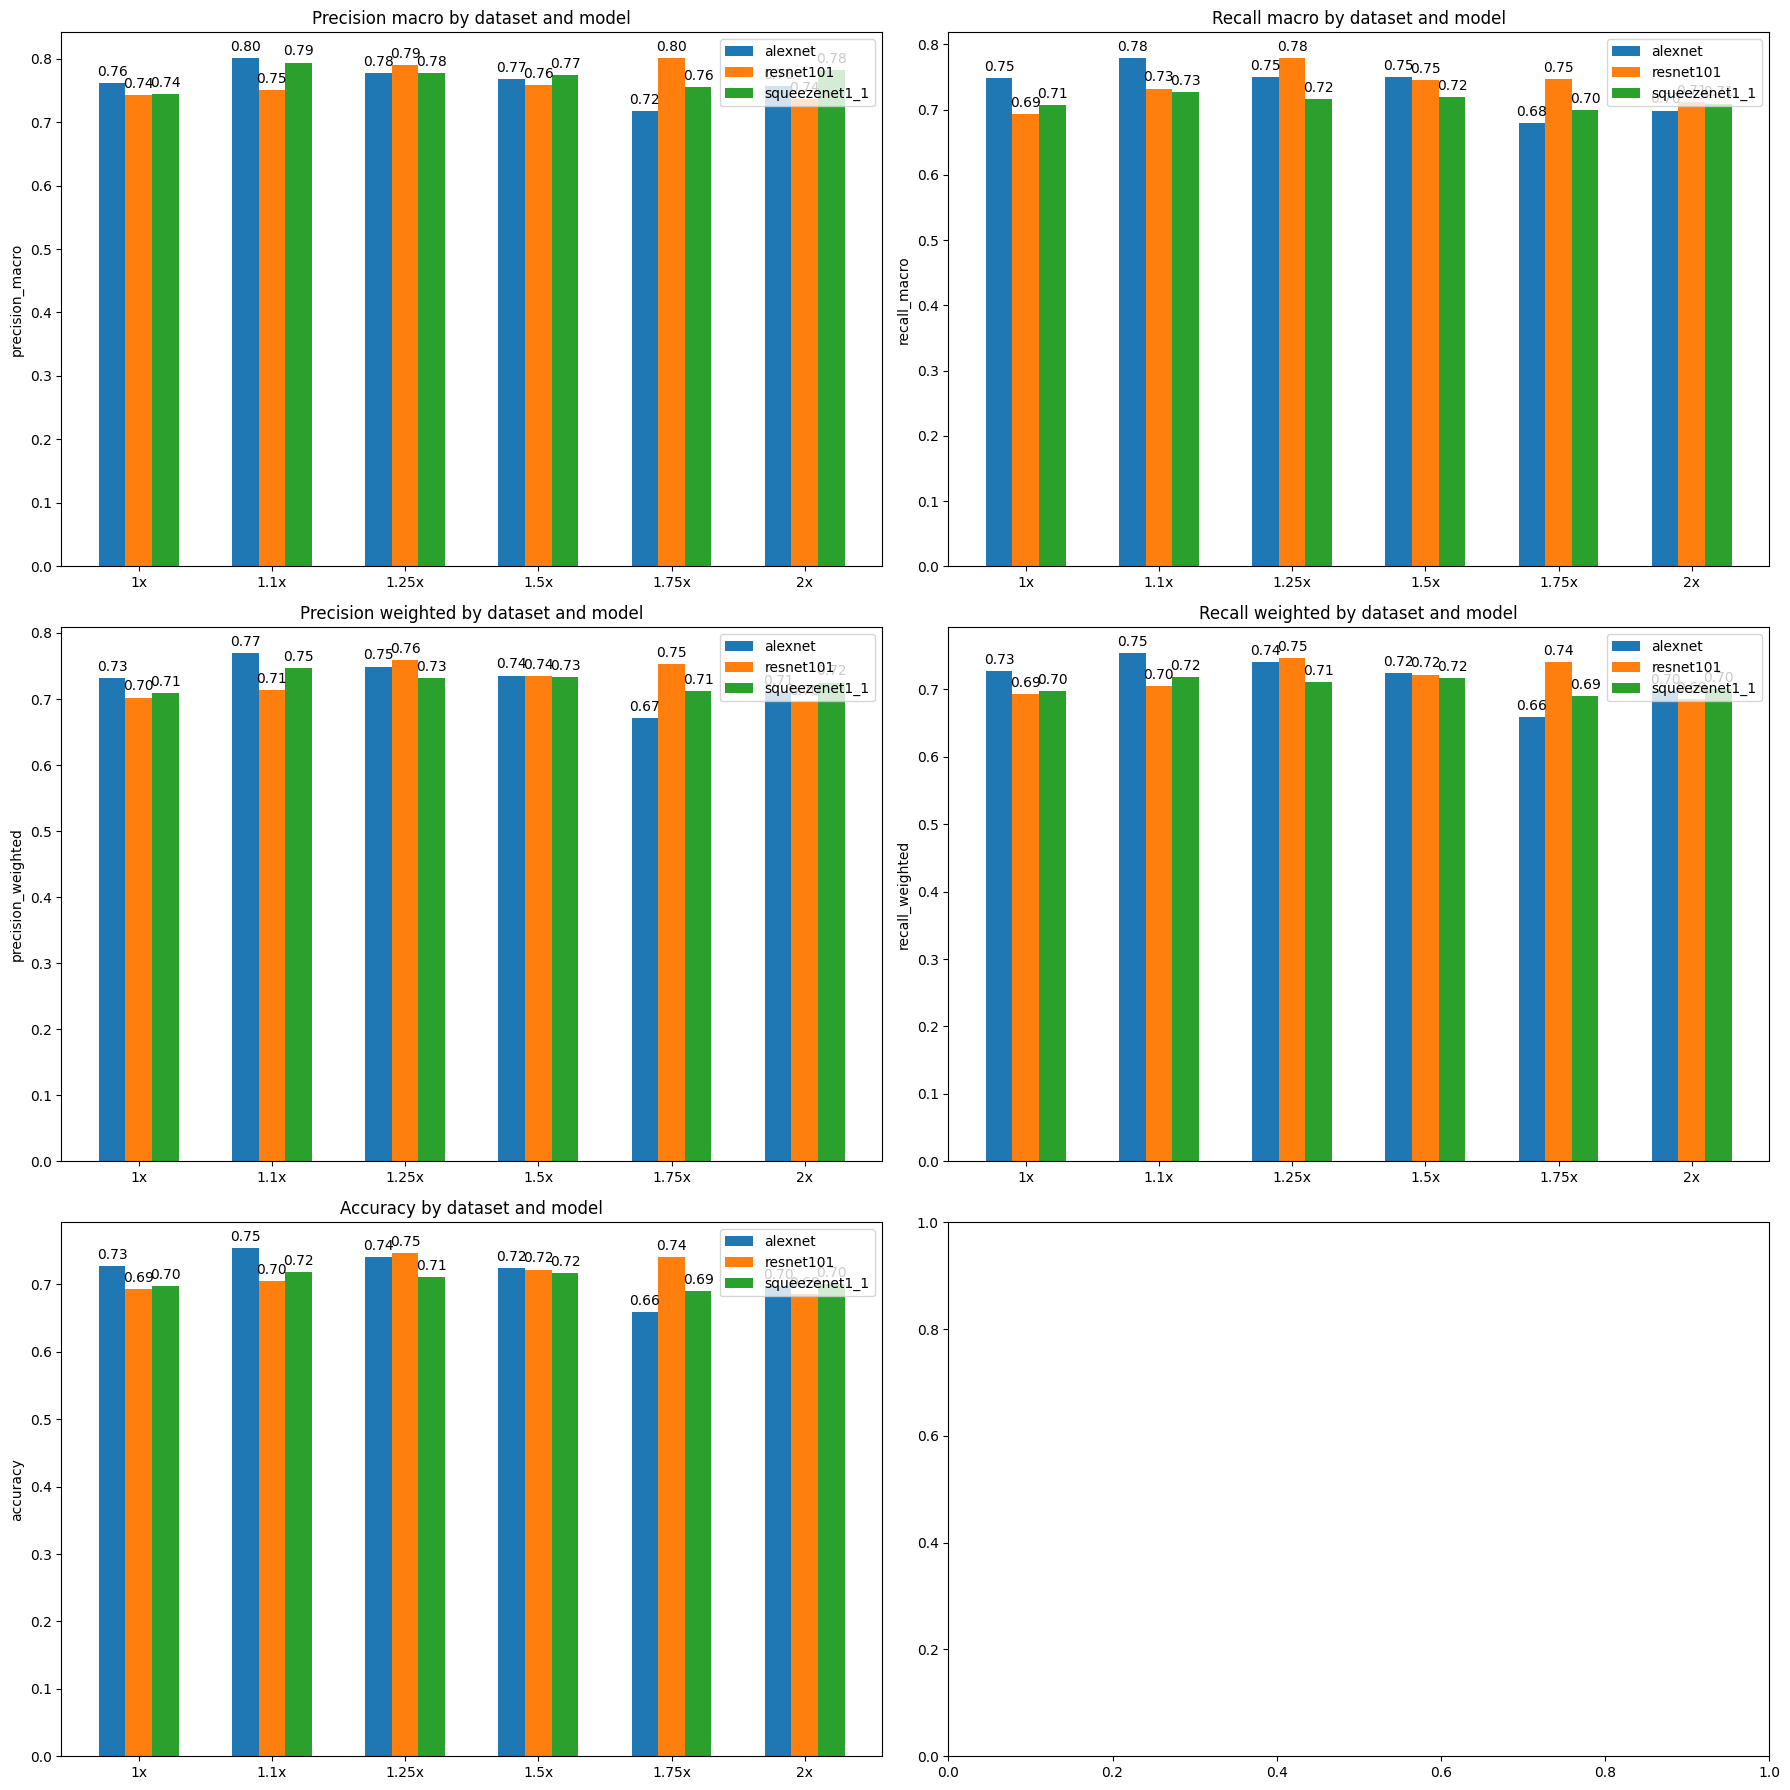

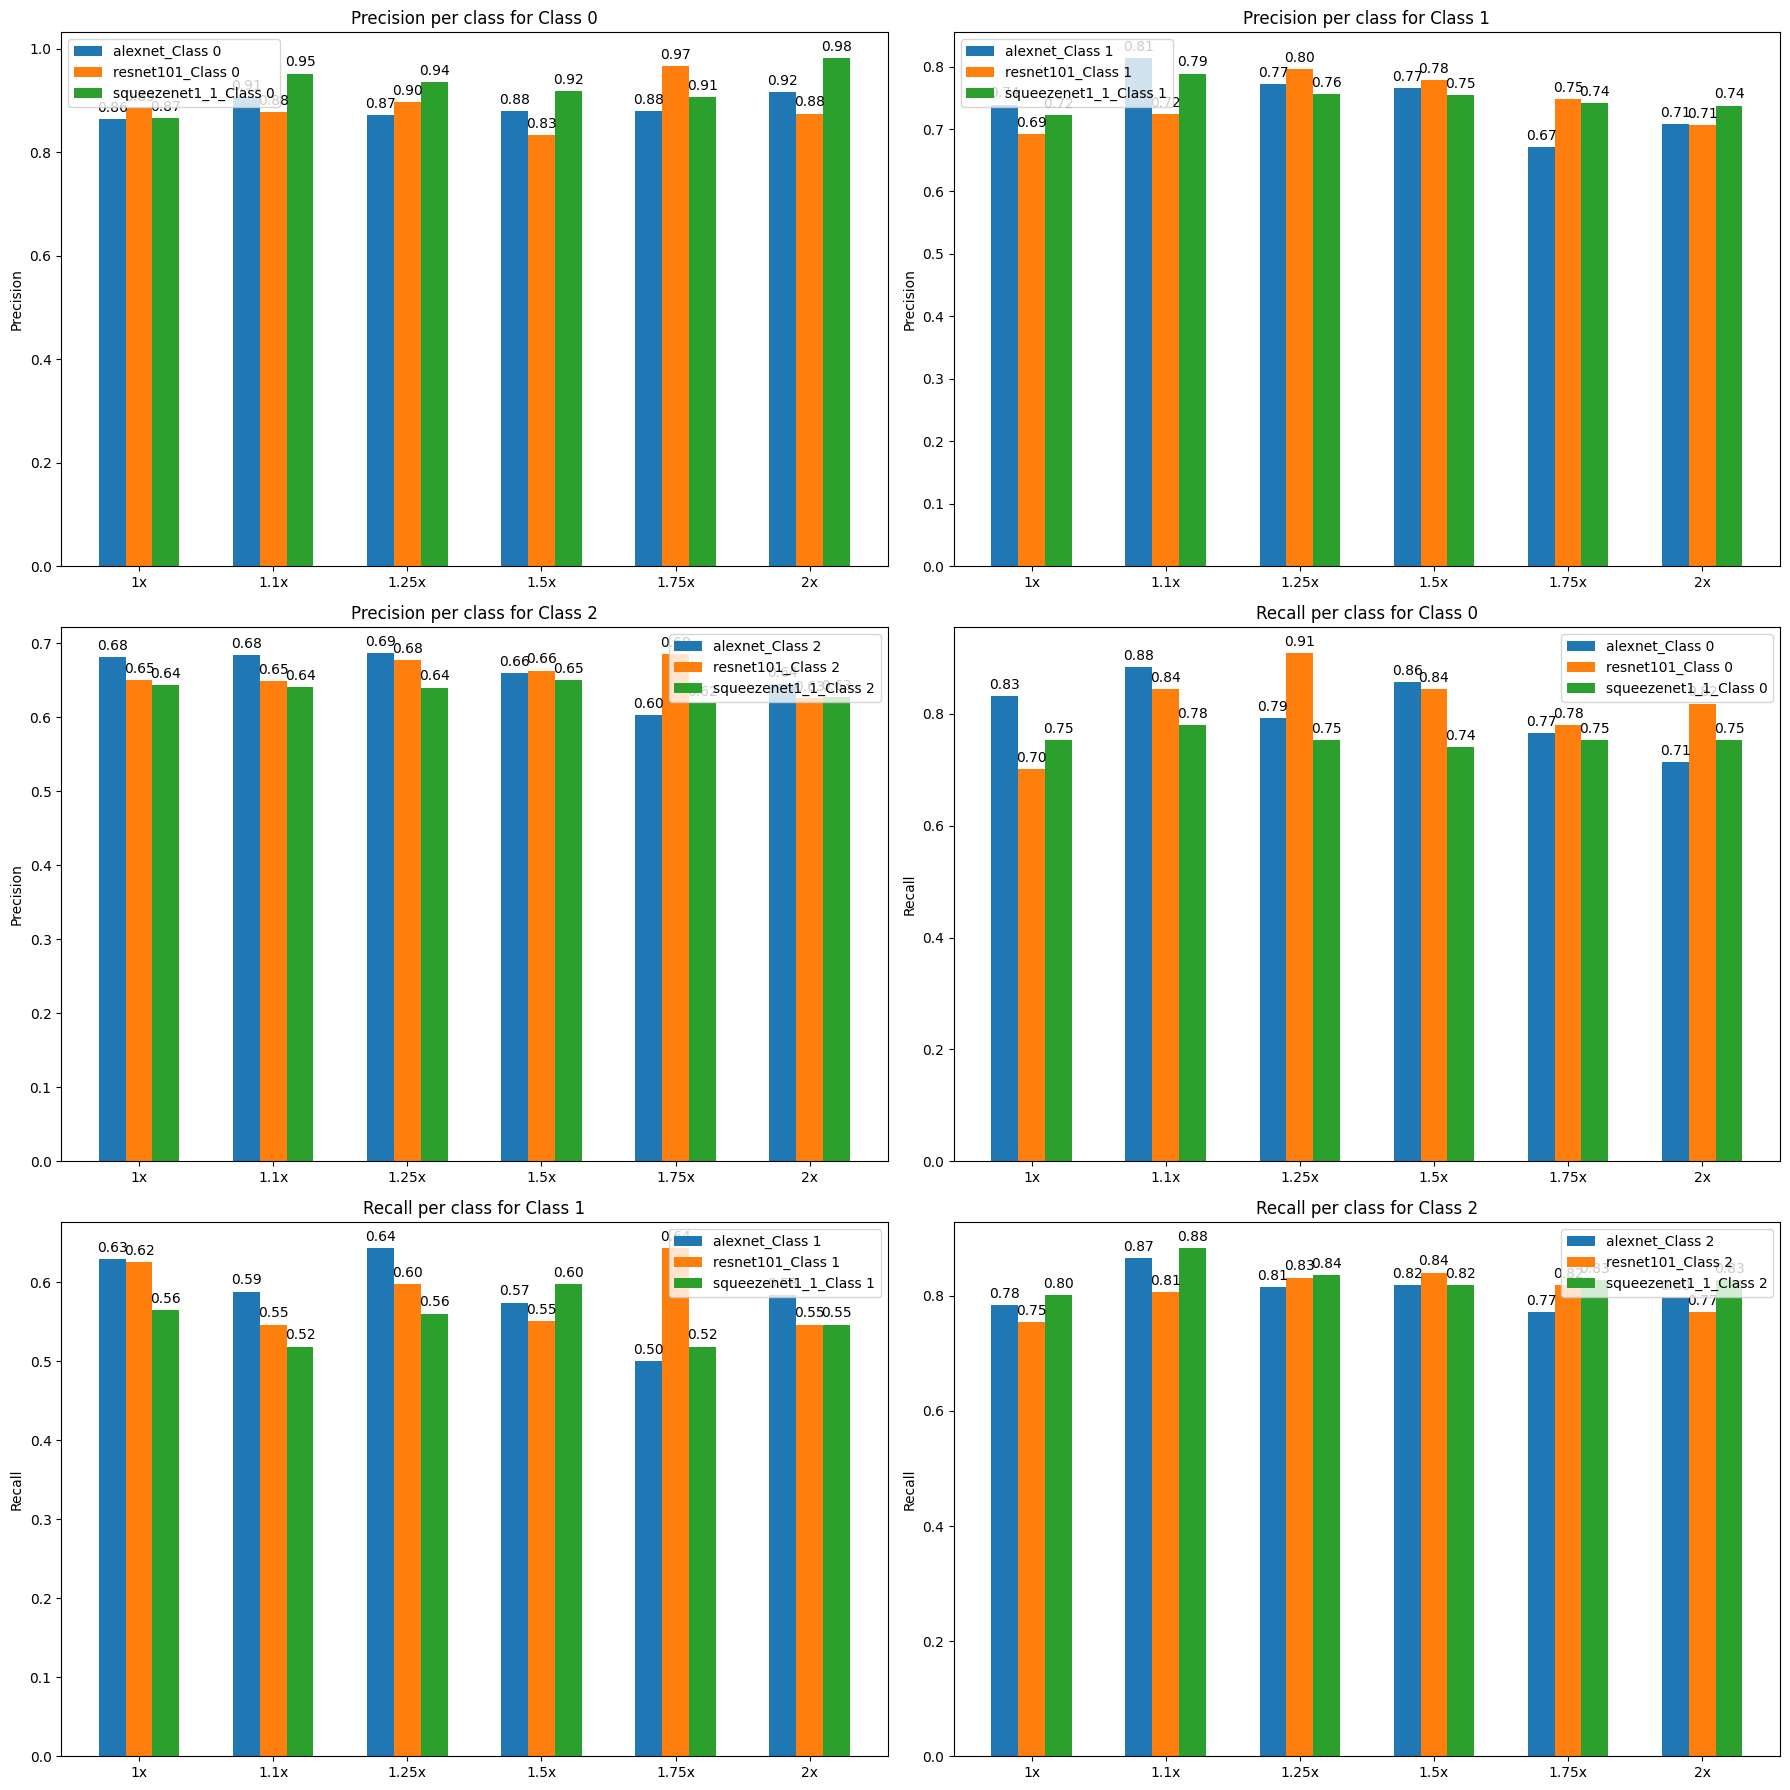

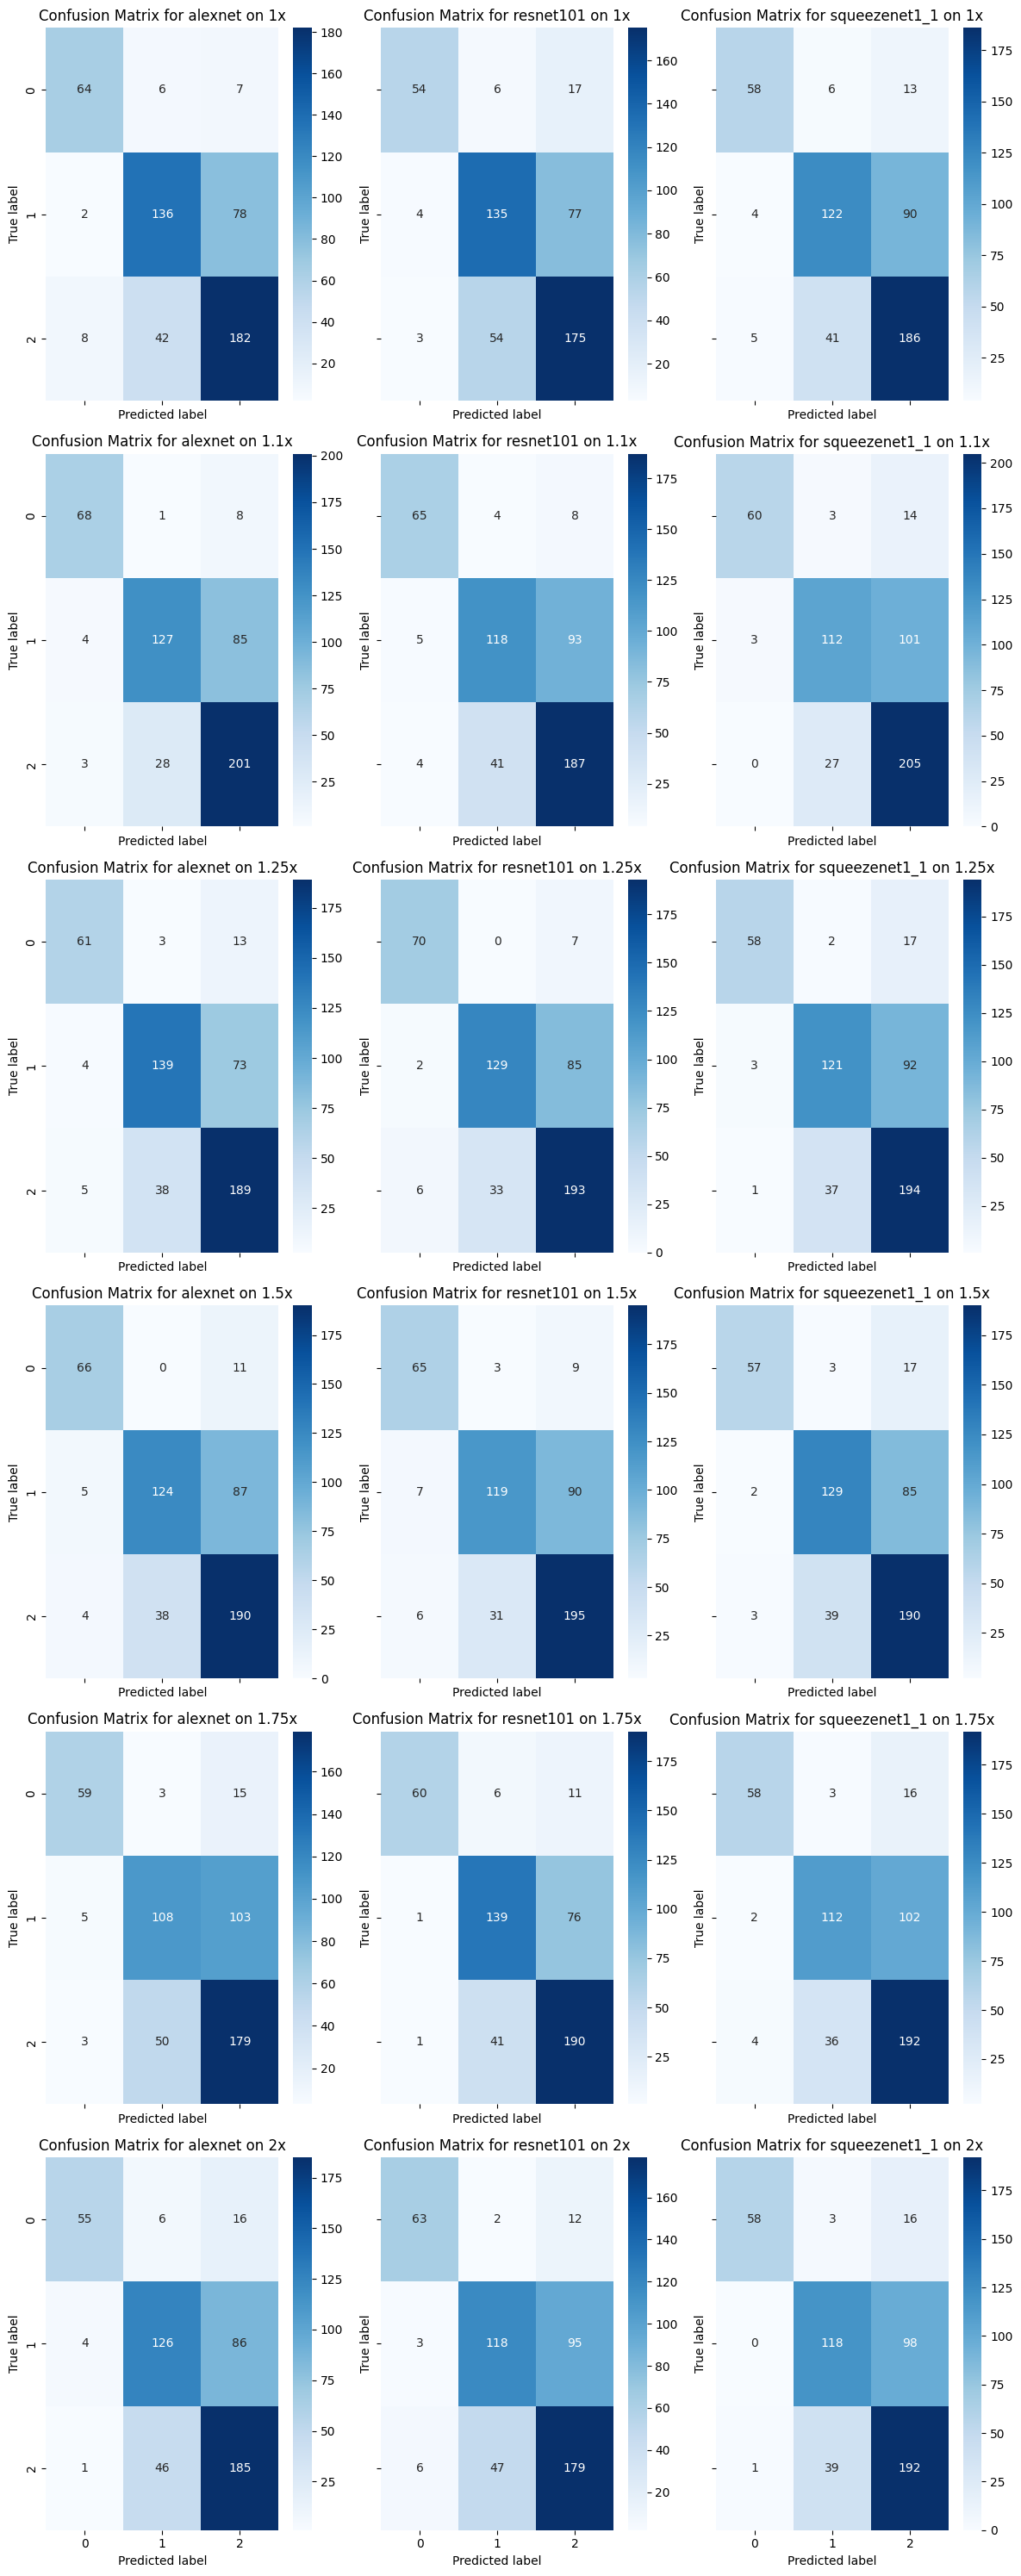

In [38]:
# Call the plot function with your results
plot_metrics(results)